In [1]:
# CATEGORY = "Baby_Products"
CATEGORY = "Video_Games"

# Define sequence lengths
MIN_SEQUENCE_LENGTH = 3
MAX_SEQUENCE_LENGTH = 100  # Adjust as needed

In [2]:
import sys
from pathlib import Path

NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
sys.path.append(str(PROJECT_ROOT))

# Data directory
DATA_DIR = Path(PROJECT_ROOT, "data")
DATA_DIR.mkdir(exist_ok=True)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from src.logger import setup_logger

logger = setup_logger("dataprep")

## Load and merge data

In [4]:
# LOAD ORIGINAL METADATA
metadata_output_path = DATA_DIR / "output" / f"{CATEGORY}_items.parquet"
item_df = pl.read_parquet(metadata_output_path)
logger.info(f"Loaded {len(item_df):,} items from {metadata_output_path}")

# LOAD AUGMENTED METADATA\
augmented_metadata_path = DATA_DIR / "output" / f"{CATEGORY}_metadata_extracted.parquet"
augmented_df = pl.read_parquet(augmented_metadata_path)
logger.info(f"Loaded {len(augmented_df):,} augmented metadata records from {augmented_metadata_path}")

# LOAD CLEANED DESCRIPTIONS
cleaned_descriptions_path = DATA_DIR / "output" / f"{CATEGORY}_descriptions_clean.csv"
cleaned_descriptions_df = pl.read_csv(cleaned_descriptions_path)
cleaned_descriptions_df = cleaned_descriptions_df.unique(subset=["parent_asin"])
cleaned_descriptions_df = cleaned_descriptions_df.filter(pl.col("clean_description") != "NA")
logger.info(f"Loaded {len(cleaned_descriptions_df):,} cleaned descriptions from {cleaned_descriptions_path}")

# LOAD CLEANED TITLES
cleaned_titles_path = DATA_DIR / "output" / f"{CATEGORY}_titles_clean.csv"
cleaned_titles_df = pl.read_csv(cleaned_titles_path)
cleaned_titles_df = cleaned_titles_df.unique(subset=["parent_asin"])
cleaned_titles_df = cleaned_titles_df.filter(pl.col("clean_title") != "NA")
logger.info(f"Loaded {len(cleaned_titles_df):,} cleaned titles from {cleaned_titles_path}")

# MERGE DATAFRAMES
item_df = item_df.join(cleaned_descriptions_df, on="parent_asin", how="inner")
item_df = item_df.join(cleaned_titles_df, on="parent_asin", how="inner")
item_df = item_df.join(augmented_df, on="parent_asin", how="left")  # Left join to keep all items
logger.info(f"Merged {len(item_df):,} items with cleaned descriptions, titles, and augmented metadata")

14:26:23 - Loaded 66,133 items from /home/zihao/llm/semantic-ids-llm/data/output/Video_Games_items.parquet
14:26:23 - Loaded 66,117 augmented metadata records from /home/zihao/llm/semantic-ids-llm/data/output/Video_Games_metadata_extracted.parquet
14:26:23 - Loaded 66,121 cleaned descriptions from /home/zihao/llm/semantic-ids-llm/data/output/Video_Games_descriptions_clean.csv
14:26:23 - Loaded 66,130 cleaned titles from /home/zihao/llm/semantic-ids-llm/data/output/Video_Games_titles_clean.csv
14:26:23 - Merged 66,118 items with cleaned descriptions, titles, and augmented metadata


In [5]:
# Clean up xml tags that remain
item_df = item_df.with_columns(
    pl.col("clean_description")
    .str.replace_all(r"</?[^>]+>", " ")  # Remove all tags
    .str.replace_all(r"\s+", " ")  # Collapse multiple spaces
    .str.strip_chars()  # Trim whitespace
    .alias("clean_description"),
    pl.col("clean_title")
    .str.replace_all(r"</?[^>]+>", " ")  # Remove all tags
    .str.replace_all(r"\s+", " ")  # Collapse multiple spaces
    .str.strip_chars()  # Trim whitespace
    .alias("clean_title"),
)

assert (
    len(
        item_df.filter(pl.col("clean_description").str.contains("clean_description")).select(
            ["description_text", "clean_description"]
        )
    )
    == 0
)
assert len(item_df.filter(pl.col("clean_title").str.contains("clean_title")).select(["title", "clean_title"])) == 0

## Description Length Analysis

In [6]:
# Calculate character lengths for original and cleaned descriptions
item_df = item_df.with_columns(
    [
        pl.col("description_text").str.len_chars().cast(pl.Int64).alias("original_desc_length"),
        pl.col("clean_description").str.len_chars().cast(pl.Int64).alias("clean_desc_length"),
        pl.col("title").str.len_chars().cast(pl.Int64).alias("original_title_length"),
        pl.col("clean_title").str.len_chars().cast(pl.Int64).alias("clean_title_length"),
    ]
)

item_df = item_df.with_columns(
    [
        (pl.col("original_desc_length") - pl.col("clean_desc_length")).cast(pl.Int64).alias("desc_char_reduction"),
        ((pl.col("original_desc_length") - pl.col("clean_desc_length")) / pl.col("original_desc_length"))
        .cast(pl.Float64)
        .alias("desc_reduction_prop"),
        (pl.col("original_title_length") - pl.col("clean_title_length")).cast(pl.Int64).alias("title_char_reduction"),
        ((pl.col("original_title_length") - pl.col("clean_title_length")) / pl.col("original_title_length"))
        .cast(pl.Float64)
        .alias("title_reduction_prop"),
    ]
)

# Calculate statistics
stats = item_df.select(
    [
        pl.col("original_desc_length").mean().alias("original_desc_mean"),
        pl.col("original_desc_length").median().alias("original_desc_median"),
        pl.col("original_desc_length").std().alias("original_desc_std"),
        pl.col("clean_desc_length").mean().alias("clean_desc_mean"),
        pl.col("clean_desc_length").median().alias("clean_desc_median"),
        pl.col("clean_desc_length").std().alias("clean_desc_std"),
        (pl.col("original_desc_length") - pl.col("clean_desc_length")).mean().alias("avg_desc_reduction"),
        ((pl.col("original_desc_length") - pl.col("clean_desc_length")) / pl.col("original_desc_length") * 100)
        .mean()
        .alias("avg_desc_reduction_pct"),
    ]
)

logger.info("Description Length Statistics:")
logger.info("=" * 50)
for col in stats.columns:
    value = stats[col][0]
    if "pct" in col:
        logger.info(f"{col}: {value:.1f}%")
    else:
        logger.info(f"{col}: {value:.1f}")

# Calculate reduction statistics
total_original_chars = item_df["original_desc_length"].sum()
total_clean_chars = item_df["clean_desc_length"].sum()
total_reduction = total_original_chars - total_clean_chars
total_reduction_pct = (total_reduction / total_original_chars) * 100

logger.info("Total Character Statistics:")
logger.info("=" * 50)
logger.info(f"Total original characters: {total_original_chars:,}")
logger.info(f"Total clean characters: {total_clean_chars:,}")
logger.info(f"Total reduction: {total_reduction:,} ({total_reduction_pct:.1f}%)")

14:27:11 - Description Length Statistics:
14:27:11 - ==================================================


14:27:11 - original_desc_mean: 1038.9
14:27:11 - original_desc_median: 643.0
14:27:11 - original_desc_std: 1456.4
14:27:11 - clean_desc_mean: 595.7
14:27:11 - clean_desc_median: 567.0
14:27:11 - clean_desc_std: 279.5
14:27:11 - avg_desc_reduction: 443.2
14:27:11 - avg_desc_reduction_pct: 12.2%
14:27:11 - Total Character Statistics:
14:27:11 - ==================================================
14:27:11 - Total original characters: 68,691,704
14:27:11 - Total clean characters: 39,389,073
14:27:11 - Total reduction: 29,302,631 (42.7%)


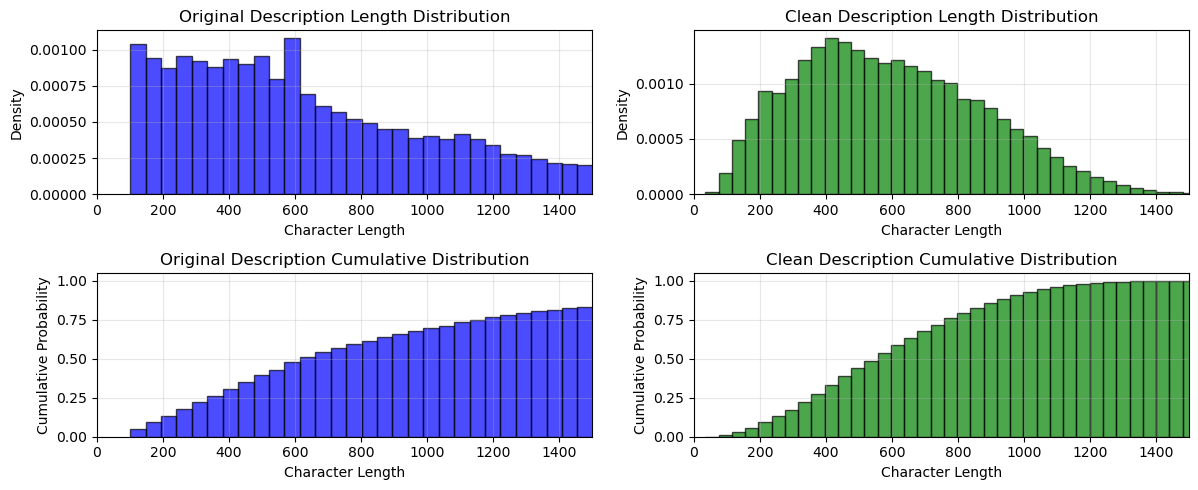

In [7]:
# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 5))
X_AXIS_LIMIT = 1500

# Convert to numpy arrays for plotting
original_lengths = item_df["original_desc_length"].to_numpy()
clean_lengths = item_df["clean_desc_length"].to_numpy()

# 1. Histogram with density for original descriptions
ax1 = axes[0, 0]
n1, bins1, patches1 = ax1.hist(original_lengths, bins=2000, density=True, alpha=0.7, color="blue", edgecolor="black")
ax1.set_xlabel("Character Length")
ax1.set_ylabel("Density")
ax1.set_title("Original Description Length Distribution")
ax1.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility
ax1.grid(True, alpha=0.3)

# 2. Histogram with density for clean descriptions
ax2 = axes[0, 1]
n2, bins2, patches2 = ax2.hist(clean_lengths, bins=50, density=True, alpha=0.7, color="green", edgecolor="black")
ax2.set_xlabel("Character Length")
ax2.set_ylabel("Density")
ax2.set_title("Clean Description Length Distribution")
ax2.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility
ax2.grid(True, alpha=0.3)

# 3. Cumulative distribution for original descriptions
ax3 = axes[1, 0]
sorted_original = np.sort(original_lengths)
cumulative_original = np.arange(1, len(sorted_original) + 1) / len(sorted_original)
ax3.hist(sorted_original, bins=2000, cumulative=True, density=True, alpha=0.7, color="blue", edgecolor="black")
ax3.set_xlabel("Character Length")
ax3.set_ylabel("Cumulative Probability")
ax3.set_title("Original Description Cumulative Distribution")
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility

# 4. Cumulative distribution for clean descriptions
ax4 = axes[1, 1]
sorted_clean = np.sort(clean_lengths)
cumulative_clean = np.arange(1, len(sorted_clean) + 1) / len(sorted_clean)
ax4.hist(sorted_clean, bins=50, cumulative=True, density=True, alpha=0.7, color="green", edgecolor="black")
ax4.set_xlabel("Character Length")
ax4.set_ylabel("Cumulative Probability")
ax4.set_title("Clean Description Cumulative Distribution")
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility

plt.tight_layout()
plt.show()

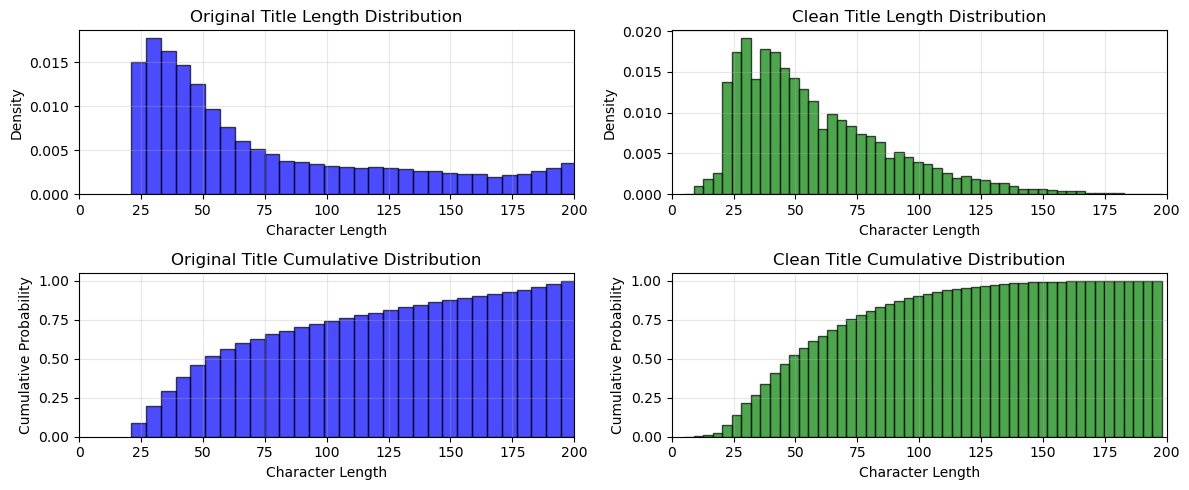

In [8]:
# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 5))
X_AXIS_LIMIT = 200

# Convert to numpy arrays for plotting
original_lengths = item_df["original_title_length"].to_numpy()
clean_lengths = item_df["clean_title_length"].to_numpy()

# 1. Histogram with density for original descriptions
ax1 = axes[0, 0]
n1, bins1, patches1 = ax1.hist(original_lengths, bins=100, density=True, alpha=0.7, color="blue", edgecolor="black")
ax1.set_xlabel("Character Length")
ax1.set_ylabel("Density")
ax1.set_title("Original Title Length Distribution")
ax1.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility
ax1.grid(True, alpha=0.3)

# 2. Histogram with density for clean descriptions
ax2 = axes[0, 1]
n2, bins2, patches2 = ax2.hist(clean_lengths, bins=50, density=True, alpha=0.7, color="green", edgecolor="black")
ax2.set_xlabel("Character Length")
ax2.set_ylabel("Density")
ax2.set_title("Clean Title Length Distribution")
ax2.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility
ax2.grid(True, alpha=0.3)

# 3. Cumulative distribution for original descriptions
ax3 = axes[1, 0]
sorted_original = np.sort(original_lengths)
cumulative_original = np.arange(1, len(sorted_original) + 1) / len(sorted_original)
ax3.hist(sorted_original, bins=100, cumulative=True, density=True, alpha=0.7, color="blue", edgecolor="black")
ax3.set_xlabel("Character Length")
ax3.set_ylabel("Cumulative Probability")
ax3.set_title("Original Title Cumulative Distribution")
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility

# 4. Cumulative distribution for clean descriptions
ax4 = axes[1, 1]
sorted_clean = np.sort(clean_lengths)
cumulative_clean = np.arange(1, len(sorted_clean) + 1) / len(sorted_clean)
ax4.hist(sorted_clean, bins=50, cumulative=True, density=True, alpha=0.7, color="green", edgecolor="black")
ax4.set_xlabel("Character Length")
ax4.set_ylabel("Cumulative Probability")
ax4.set_title("Clean Title Cumulative Distribution")
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility

plt.tight_layout()
plt.show()

In [9]:
# Get sample of clean descriptions with less than 200 chars, sorted by highest percentage reduction
short_clean_sample = (
    item_df.filter(pl.col("clean_desc_length") < 200)
    .sort("desc_reduction_prop", descending=True)
    .select(
        [
            "parent_asin",
            "title",
            "original_desc_length",
            "clean_desc_length",
            "desc_char_reduction",
            "desc_reduction_prop",
            "description_text",
            "clean_description",
        ]
    )
)
logger.info(f"Short clean sample: {len(short_clean_sample):,}")

pl.Config.set_fmt_str_lengths(500)
pl.Config.set_tbl_rows(50)
short_clean_sample.select(
    ["description_text", "clean_description", "original_desc_length", "clean_desc_length", "desc_reduction_prop"]
).head(5)

14:28:03 - Short clean sample: 3,914


description_text,clean_description,original_desc_length,clean_desc_length,desc_reduction_prop
str,str,i64,i64,f64
"""Item specifics Condition: New: A brand-new, unused, unopened, undamaged item in its original packaging (where packaging is applicable). Packaging should be the same as what is found in a retail store, unless the item is handmade or was packaged by the manufacturer in non-retail packaging, such as an unprinted box or plastic bag. MPN: NXN64-063 Connectivity: Wired Type: Gamepads Country/Region of Manufacture: China Platform: Nintendo 64 Color: Green Brand: TTX Tech""","""New TTX Tech wired gamepad for Nintendo 64 in vibrant green. MPN: NXN64-063. Manufactured in China.""",468,99,0.788462
"""The Last of Us 2 - STEELBOOK ONLY (NO Game - Steelbook Only) THE LAST OF US PART II, The Last of US 2 - ??? ??(?? ?? - ??? ??) ?? ??? ?? II, The Last of Us 2 - ????(??? - ????)???????, The Last of US 2 - STEELBOOK SOLO (sin juego - Steelbook Only) The Last of US Part II, The Last of Us 2 - ?? STEELBOOK (??? - ??????)??????? II, ?????? ?????? 2 - STEELBOOK ???? (??? ???? - Steelbook ????) ?????? ?????? ??? ? ', ???? The Last of Us 2 - STEELBOOK Only (???? ???? - ???? ???? ???) THE LAST OF US ????…","""This is the Steelbook edition for The Last of Us Part II. Please note that this listing is for the Steelbook case only and does not include the game disc.""",678,154,0.772861
"""VR Gaming Accessories for Oculus Quest 2 FPS Games, VR Gaming Accessories for Oculus Quest 2 FPS Games, VR Gaming Accessories for Oculus Quest 2 FPS Games, VR Gaming Accessories for Oculus Quest 2 FPS Games""","""VR Gaming Accessories for Oculus Quest 2 FPS Games.""",206,51,0.752427
"""Elite Dangerous Legendary Edition (PS4)Elite Dangerous Legendary Edition (PS4)Elite Dangerous Legendary Edition (PS4)Elite Dangerous Legendary Edition (PS4)""","""Elite Dangerous Legendary Edition (PS4)""",156,39,0.75
"""Item specifics Condition: New: A brand-new, unused, unopened, undamaged item in its original packaging (where packaging is applicable). Packaging should be the same as what is found in a retail store, unless the item is handmade or was packaged by the manufacturer in non-retail packaging, such as an unprinted box or plastic bag. Brand: HYPERKIN""","""New, unused, unopened, and undamaged HYPERKIN product in its original retail packaging.""",346,87,0.748555


In [10]:
pl.Config.set_fmt_str_lengths(1000)
item_df.sort("desc_char_reduction", descending=True).select(
    [
        "description_text",
        "clean_description",
        "original_desc_length",
        "clean_desc_length",
        "desc_char_reduction",
        "desc_reduction_prop",
    ]
).head(5)

description_text,clean_description,original_desc_length,clean_desc_length,desc_char_reduction,desc_reduction_prop
str,str,i64,i64,i64,f64
"""Product description The PSP (PlayStation Portable) system is the first truly integrated portable entertainment system designed to handle multiple applications - music, video, photo, internet, and wireless connectivity, with games as its key feature. The PSP system features an unmatched library of entertainment content, combining more than 135 games and more than 430 feature films, TV programs, and videos on UMD from major studios and record labels, as well as downloadable content from the internet. The PSP is more than a portable game system, it's a lifestyle. Like life, it is constantly evolving - moving towards newer levels of technology and entertainment. This special pack is a great way to join the fun! Dazzling widescreen LCD brings gaming to life With Wi-Fi functionality you can go online with your PSP or communicate directly with other PSP systems. Play games online, browse the web and more. Daxter gives the co-star of the popular Jak & Daxter games his own adventure! Play from …","""The PlayStation Portable (PSP) is a versatile handheld entertainment system that offers games, music, video, photos, and internet connectivity. It boasts an extensive library of over 135 games and more than 430 feature films, TV programs, and videos on UMD, along with downloadable content. Experience gaming on its dazzling 4.3-inch widescreen LCD, featuring graphics comparable to PlayStation®2. Built-in Wi-Fi enables online play, web browsing, and direct communication with other PSP systems. This special pack includes ""Daxter,"" a unique platformer where you play as the co-star from the Jak & Daxter series. Experience his back-story from an ottsel's perspective, utilizing agile moves like crawling and fitting into small spaces to navigate Haven City.""",93558,759,92799,0.991887
"""Product description Haven't joined the PSP generation yet? This PSP Limited Edition Star Wars Battlefront Pack is ready to help you launch. The PSP (PlayStation Portable) system is the first truly integrated portable entertainment system designed to handle multiple applications - music, video, photo, internet, and wireless connectivity, with games as its key feature. The PSP system features an unmatched library of entertainment content, combining more than 135 games and more than 430 feature films, TV programs, and videos on UMD from major studios and record labels, as well as downloadable content from the internet. It is constantly evolving to fit your lifestyle - on the web, as MP3 or MP4 player, go WiFi, and beyond. Great games and graphics display on bright integrated widescreen. Uses MemoryStick Pro storage. With PSP, the force will be with you! Amazon.com PSP is the first truly integrated handheld entertainment system designed to handle multiple applications — music, video, commu…","""Embark on your portable entertainment journey with the PSP Limited Edition Star Wars Battlefront Pack. This PlayStation Portable (PSP) system is a versatile entertainment hub, offering games, music, video, photos, and internet connectivity. Experience an extensive library of over 135 games and 430 UMDs featuring movies, TV shows, and videos from major studios and record labels, plus downloadable content. Its capabilities extend to MP3/MP4 playback and WiFi for seamless online access. Enjoy stunning graphics on the bright, integrated widescreen display, with rendering power comparable to PlayStation 2. The system uses the high-capacity Universal Media Disc (UMD) for storage. This Ceramic White Entertainment Pack includes the PSP system, AC power cord and adapter, battery, and the Star Wars Battlefront: Renegade Squadron game. The PSP seamlessly integrates into your lifestyle, offering a superior handheld gaming and entertainment experience.""",93108,953,92155,0.989765
"""Product description Open the door to a whole new world of learning at

In [11]:
# Get sample of clean descriptions with less than 200 chars, sorted by highest percentage reduction
short_clean_sample = (
    item_df.filter(pl.col("clean_title_length") < 200)
    .sort("title_reduction_prop", descending=True)
    .select(
        [
            "parent_asin",
            "original_title_length",
            "clean_title_length",
            "title_char_reduction",
            "title_reduction_prop",
            "title",
            "clean_title",
        ]
    )
)
logger.info(f"Short clean sample: {len(short_clean_sample):,}")

pl.Config.set_fmt_str_lengths(500)
pl.Config.set_tbl_rows(50)
short_clean_sample.select(
    ["title", "clean_title", "original_title_length", "clean_title_length", "title_reduction_prop"]
).head(5)

14:31:23 - Short clean sample: 66,118


title,clean_title,original_title_length,clean_title_length,title_reduction_prop
str,str,i64,i64,f64
"""The Sims - The People Simulator from the Creator of SimCity""","""The Sims""",59,8,0.864407
"""PLANEX Portable 3G/4G Wireless N Router Mobile Router - EN, Fast EN, IEEE 802.11b, IEEE 802.11g, IEEE 802.11n WiFi Mobile Broadband Pocket Router Router with 4-port switch compatible WCDMA/HSDPA/HSUPA 3G USB Modems, Portable IEEE802.11n/b/g WiFi 150Mbps Network Router/AP for Mac OS, Windows-Supports Multi SSID and Gaming Machines; Nintendo DS/DSi/Wii, Sony Play Station PSP/PS3, Xbox360/CQW-MR500 Designed in Japan""","""PLANEX Portable 3G/4G Wireless N Router with 4-Port Switch""",416,58,0.860577
"""Screen Protector Tempered Glass for Nintendo Switch Lite 2019 Anti-Fall and Scratch. Screen Protector Tempered Glass for Nintendo Switch Lite 2019 Anti-Fall and Scratch. Screen Protector Tempered Glass for Nintendo Switch Lite 2019 Anti-Fall and Scratch. Screen Protector Tempered Glass for Nintendo Switch Lite 2019 Anti-Fall and Scratch. Screen Protector Tempered Glass for Nintendo Switch Lite 2019 Anti-Fall and Scratch.""","""Tempered Glass Screen Protector for Nintendo Switch Lite (2019)""",424,63,0.851415
"""Crusader of Centy by Atlus was one of the few games for the Sega Genesis made to compete with Nintendo's The Legend of Zelda franchise. It remains one of the rarest games to find for the Sega Genesis.""","""Crusader of Centy - Sega Genesis""",200,32,0.84
"""Gemini Mouse Grip Tape Compatible with Razer Viper Mini,Grips,Mouse Grips|Mouse Skin,Gaming Mouse Skins,Mouse Grip,Razer mouse grip tape|Razer mouse ,Razer grip tape ,mouse griptape ,razer mouse grips""","""Razer Viper Mini Mouse Grip Tape""",200,32,0.84


In [12]:
pl.Config.set_fmt_str_lengths(1000)
item_df.sort("title_char_reduction", descending=True).select(
    [
        "title",
        "clean_title",
        "original_title_length",
        "clean_title_length",
        "title_char_reduction",
        "title_reduction_prop",
    ]
).head(5)

title,clean_title,original_title_length,clean_title_length,title_char_reduction,title_reduction_prop
str,str,i64,i64,i64,f64
"""Gaming Keyboard Blue LED Backlit Sentey® Phoenix Gs-5700 / Blue Led Lightning Illuminated Key's / Replaceable Orange Gaming Keys Wasd / 114 Keys / 7 Macrokeys / Software / Carry Bag for Transport / Extreme Series / 8 Rollover Keys / 50 Million Times / 50g Acuation Force / 128k On-board Memory to Record Profiles / 3 Different Levels of Light Brightness / Windows Lock Key Feature / 3 Profiles Setup / 1.8 All Braided Cable / USB 2.0 Gold Plated USB Connector / All Black Rubber Coating Painting / Weight 663.5g (1.46lbs) / Cable Management with Velcro Straps / USB Cap Connector - Connector Cap / Keycap Laser Engraving""","""Sentey Phoenix GS-5700 Gaming Keyboard with Blue LED Backlighting, 7 Macro Keys, Software, and Carry Bag""",620,104,516,0.832258
"""Sentey® Gaming Headset Blue Arrow Analog 3.5mm In-line Volume Control & Computer Headset with Microphone Gaming Headphones Headphone Pc, Mac or Laptop, Tablet, Mobile Phones / Headset with Mic Heavy Duty Braided 2 Meters Cable / Leather Padded Ear Pads with Passive Noise Canceling / Computer Gaming Headset Ergonomic Adaptive Leather Headband (Extreme Comfort) - Computer Gaming Headset Stereo Left and Right Drivers 40mm / Cap Connector / Computer Headset to Work and Play / Skype Headset - Gaming Headsets for Chat and Play Gs-4520""","""Sentey Blue Arrow Analog Gaming Headset with Microphone and In-line Volume Control - PC, Mac, Tablet, Mobile""",534,108,426,0.797753
"""Sentey® Gaming Headset Red Arrow Analog 3.5mm In-line Volume Control & Computer Headset with Microphone Gaming Headphones Headphone Pc, Mac or Laptop, Tablet, Mobile Phones / Headset with Mic Heavy Duty Braided 2 Meters Cable / Leather Padded Ear Pads with Passive Noise Canceling / Computer Gaming Headset Ergonomic Adaptive Leather Headband (Extreme Comfort) - Computer Gaming Headset Stereo Left and Right Drivers 40mm / Cap Connector / Computer Headset to Work and Play / Skype Headset - Gaming Headsets for Chat and Play Gs-4521""","""Sentey Red Arrow Analog Gaming Headset with Microphone and In-line Volume Control for PC, Mac, Laptop, Tablet, Mobile Phones""",533,124,409,0.767355
"""Screen Protector Tempered Glass for Nintendo Switch Lite 2019 Anti-Fall and Scratch. Screen Protector Tempered Glass for Nintendo Switch Lite 2019 Anti-Fall and Scratch. Screen Protector Tempered Glass for Nintendo Switch Lite 2019 Anti-Fall and Scratch. Screen Protector Tempered Glass for Nintendo Switch Lite 2019 Anti-Fall and Scratch. Screen Protector Tempered Glass for Nintendo Switch Lite 2019 Anti-Fall and Scratch.""","""Tempered Glass Screen Protector for Nintendo Switch Lite (2019)""",424,63,361,0.851415
"""PLANEX Portable 3G/4G Wireless N Router Mobile Router - EN, Fast EN, IEEE 802.11b, IEEE 802.11g, IEEE 802.11n WiFi Mobile Broadband Pocket Router Router with 4-port switch compatible WCDMA/HSDPA/HSUPA 3G USB Modems, Portable IEEE802.11n/b/g WiFi 150Mbps Network Router/AP for Mac OS, Windows-Supports Multi SSID and Gaming Machines; Nintendo DS/DSi/Wii, Sony Play Station PSP/PS3, Xbox360/CQW-MR500 Designed in Japan""","""PLANEX Portable 3G/4G Wireless N Router with 4-Port Switch""",416,58,358,0.860577


In [13]:
pl.Config.restore_defaults()
item_df = item_df.rename(
    {
        "description_text": "original_description",
        "clean_description": "description_text",
        "title": "original_title",
        "clean_title": "title",
    }
)
item_df.head()

parent_asin,original_title,original_description,features_text,main_category,categories_text,store,average_rating,rating_number,price,item_context,description_text,title,genre,brand,product_type,platform,hardware_type,franchise,multiplayer,original_desc_length,clean_desc_length,original_title_length,clean_title_length,desc_char_reduction,desc_reduction_prop,title_char_reduction,title_reduction_prop
str,str,str,str,str,str,str,str,i64,str,str,str,str,list[str],str,str,list[str],str,str,str,i64,i64,i64,i64,i64,f64,i64,f64
"""B09NLTZMBT""","""LightPro Dockable Case for Nin…","""LightPro Switch Protective Cas…","""【Cute and Lovly】Exclusive Saku…","""Video Games""","""Video Games > Nintendo Switch …","""LightPro""","""4.6""",370,"""19.98""","""Product: LightPro Dockable Cas…","""Enhance your Nintendo Switch w…","""LightPro Dockable Case for Nin…",null,"""LightPro""","""Accessory""","[""Nintendo Switch""]","""Case""",null,null,1000,697,162,87,303,0.303,75,0.462963
"""B00HVU0Y44""","""CirKa N64 Controller: Grape Pu…","""CirKa N64 Controller: Grpe Pur…","""""","""Video Games""","""Video Games > Legacy Systems >…","""Cirka""","""3.9""",38,"""""","""Product: CirKa N64 Controller:…","""The CirKa N64 Wired Controller…","""CirKa N64 Controller - Grape P…",null,"""CirKa""","""Accessory""","[""Nintendo 64""]","""Controller""",null,null,522,423,47,35,99,0.189655,12,0.255319
"""B00VF1MVXC""","""247 Skins Graphics kit Sticker…","""This listing is for a vinyl de…","""Precision cut for a profession…","""Video Games""","""Video Games > Legacy Systems >…","""247Skins""","""4.8""",17,"""12.95""","""Product: 247 Skins Graphics ki…","""Enhance your PlayStation 3 Sup…","""247 Skins Meltdown Graphics Ki…",null,"""247 Skins""","""Accessory""","[""PS3""]","""Skin""",null,null,304,356,118,104,-52,-0.171053,14,0.118644
"""B072X8CNJ4""","""Dollermy Gaming Mouse 3200 DPI…","""Ergonomic design, internally a…","""1200/1600/2400/3200 4 DPI Leve…","""All Electronics""","""Video Games > PC > Accessories…","""Dollermy""","""3.5""",17,"""""","""Product: Dollermy Gaming Mouse…","""Experience the ultimate gaming…","""Dollermy Gaming Mouse - 3200 D…",null,"""Dollermy""","""Accessory""","[""PC""]","""Gaming Mice""",null,null,418,524,114,90,-106,-0.253589,24,0.210526
"""B00EMIVN5C""","""Assecure Metal Extendable Styl…","""The Assecure 3DS XL White meta…","""5 x White 3DS XL stylus includ…","""Computers""","""Video Games > Legacy Systems >…","""Assecure""","""5.0""",2,"""""","""Product: Assecure Metal Extend…","""Enhance your Nintendo 3DS XL g…","""Assecure Metal Extendable Styl…",null,"""Assecure""","""Accessory""","[""Nintendo 3DS XL""]","""Stylus Pen""",null,null,331,452,77,67,-121,-0.365559,10,0.12987


In [14]:
# Coalesce categories
item_df = item_df.with_columns(
    pl.when(pl.col("categories_text") == "")
    .then(pl.col("main_category"))
    .otherwise(pl.col("categories_text"))
    .alias("categories_text")
)

assert len(item_df.filter(pl.col("categories_text") == "").select(["categories_text", "main_category"])) == 0

In [15]:
# Create item_context with augmented metadata
context_parts = [
    pl.lit("Product: "),
    pl.col("title"),
    pl.lit("\nDescription: "),
    pl.col("description_text"),
    pl.lit("\nCategory: "),
    pl.col("categories_text"),
]

# Add augmented metadata if available
if "product_type" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nProduct Type: "),
            pl.col("product_type").fill_null("Unknown"),
        ]
    )

if "platform" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nPlatform: "),
            pl.col("platform").list.join(", ").fill_null("N/A"),
        ]
    )

if "genre" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nGenre: "),
            pl.col("genre").list.join(", ").fill_null("N/A"),
        ]
    )

if "brand" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nBrand: "),
            pl.col("brand").fill_null("Unknown"),
        ]
    )

if "multiplayer" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nMultiplayer: "),
            pl.col("multiplayer").fill_null("Unknown"),
        ]
    )

if "franchise" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nFranchise: "),
            pl.col("franchise").fill_null("N/A"),
        ]
    )

item_df = item_df.with_columns(pl.concat_str(context_parts).alias("item_context"))

pl.Config.set_fmt_str_lengths(1000)
item_df.select(["item_context"]).head(5)

item_context
str
"""Product: LightPro Dockable Case for Nintendo Switch with Cat Paw Thumb Grips - Purple Sakura Cat Description: Enhance your Nintendo Switch with the LightPro Protective Case, featuring an exclusive and vibrant Sakura Cat design. This ultra-thin, lightweight case offers robust protection without hindering comfort or causing overheating, thanks to its breathable design. The separable construction allows easy Joy-Con removal and supports stand mode, offering versatile gameplay options. Crafted from high-quality TPU, this case is specifically designed for the Nintendo Switch and is not compatible with the Nintendo Switch Lite. The package includes the protective case, a LightPro cleaning cloth, and two thumb grip caps. We are committed to customer satisfaction and offer support for any quality issues. Category: Video Games > Nintendo Switch > Accessories > Cases & Storage Product Type: Accessory Platform: Nintendo Switch Genre: N/A Brand: LightPro Multiplayer: Unknown Franchise: N/A"""
"""Product: CirKa N64 Controller - Grape Purple Description: The CirKa N64 Wired Controller in Grape Purple is the perfect replacement for a broken or lost Nintendo 64 controller. Designed for functionality and comfort, it offers an ergonomic grip for extended gameplay. This controller features an 8-way directional pad and a slot for your Memory Card or Rumble Pack, giving you the edge you need. It's an ideal choice for a second controller or as a direct replacement for your N64. Category: Video Games > Legacy Systems > Nintendo Systems > Nintendo 64 > Accessories Product Type: Accessory Platform: Nintendo 64 Genre: N/A Brand: CirKa Multiplayer: Unknown Franchise: N/A"""
"""Product: 247 Skins Meltdown Graphics Kit Sticker Decal for PS3 PlayStation 3 Super Slim and Dualshock Controllers Description: Enhance your PlayStation 3 Super Slim console and controllers with this custom vinyl decal. Not only does it provide a unique, personalized look, but it also offers protection against minor scratches. The decal is simple to apply and can be removed cleanly, leaving no sticky residue. Customize your gaming experience with this easy-to-use protective skin. Category: Video Games > Legacy Systems > PlayStation Systems > PlayStation 3 > Accessories > Faceplates, Protectors & Skins > Skins Product Type: Accessory Platform: PS3 Genre: N/A Brand: 247 Skins Multiplayer: Unknown Franchise: N/A"""
"""Product: Dollermy Gaming Mouse - 3200 DPI, 8 Buttons, USB Wired, Optical with 4 Color LED Backlight Description: Experience the ultimate gaming concept with this ergonomically designed mouse, built for comfort and performance. It offers plug-and-play functionality with no drivers required. The unique 'breathing' LED light provides a calming ambient glow. Constructed from durable, anti-fall metal, this mouse also features subtle button sounds. Specifications: * **Base Material:** Metal * **Keys:** 8 * **LED Light:** 4-color * **Interface:** USB 2.0 * **Wire Length:** Approx. 1.3m * **Resolution:** 3200 DPI * **Color:** Silver Gray Category: Video Games > PC > Accessories > Gaming Mice Product Type: Accessory Platform: PC Genre: N/A Brand: Dollermy Multiplayer: Unknown Franchise: N/A"""
"""Product: Assecure Metal Extendable Stylus for Nintendo 3DS XL - 5 Pack White Description: Enhance your Nintendo 3DS XL gaming experience with the Assecure 3DS XL White Metal Stylus Pack. This set includes five replacement styluses designed for greater accuracy than finger input on the touchscreen. Each stylus features an attractive all-black finish and is engineered to fit seamlessly into the 3DS XL console's storage slot, just like the original. The metal construction offers durability and a comfortable grip for extended play sessions. Category: Video Games > Legacy Systems > Nintendo Systems > Nintendo DS > Accessories > Stylus Pens Product Type: Accessory Platform: Nintendo 3DS XL Genre: N/A Brand: Assecure Multiplayer: Unknown Franchise: N/A"""


In [16]:
item_df.select(["original_title", "original_description", "title", "description_text"]).head(5)

original_title,original_description,title,description_text
str,str,str,str
"""LightPro Dockable Case for Nintendo Switch - Cute Protective Cover Case for Switch Console and Joy-Con with Cat Paw Thumb Grips, Anti-Scratch -- Purple Sakura Cat""","""LightPro Switch Protective Case Features: Exclusive Design -- The cute Sakura Cat design is original and unique, no more boring black or gray color, adds flavor and vitality into your Switch. Ultra-thin and Comfortable -- This protective case is ultra-thin, sturdy but lightweight and the breathing hole will not make your consoles be hot, makes playing more comfortable. Separable Design -- You can easily remove the Joy without having to remove the entire casing, support stand mode, so you can play the game the way you like. Specifications: Material - high quality TPU materials Package Includes: 1 x N-Switch Protective Case 1 x LightPro Cleaning Cloth 2 x Thumb Grip Caps Note: 1.Designed specifically for Nintendo Switch, not suitable for Nintendo Switch Lite. 2.Quality/Warranty -- If you find any problems (damage, scratches, dirt, etc.), please feel free to contact us. Our shop always strives for customer satisfaction and always does our best to meet customer needs with better quality.""","""LightPro Dockable Case for Nintendo Switch with Cat Paw Thumb Grips - Purple Sakura Cat""","""Enhance your Nintendo Switch with the LightPro Protective Case, featuring an exclusive and vibrant Sakura Cat design. This ultra-thin, lightweight case offers robust protection without hindering comfort or causing overheating, thanks to its breathable design. The separable construction allows easy Joy-Con removal and supports stand mode, offering versatile gameplay options. Crafted from high-quality TPU, this case is specifically designed for the Nintendo Switch and is not compatible with the Nintendo Switch Lite. The package includes the protective case, a LightPro cleaning cloth, and two thumb grip caps. We are committed to customer satisfaction and offer support for any quality issues."""
"""CirKa N64 Controller: Grape Purple for Nintendo""","""CirKa N64 Controller: Grpe Purple for Nintendo 64 Replace your broken or lost Nintendo 64 controller with the CirKA N64 Wired Controller. Built with functionality in mind, the CirKA N64 Wired Controller gives you the edge. Pick one up as a second controller, or as a replacement controller for your N64. Features 8-way directional pad 8-way directional pad Ergonomic design provides comfort for extended play Ergonomic design provides comfort for extended play Memory Card / Rumble Pack Slot Memory Card / Rumble Pack Slot""","""CirKa N64 Controller - Grape Purple""","""The CirKa N64 Wired Controller in Grape Purple is the perfect replacement for a broken or lost Nintendo 64 controller. Designed for functionality and comfort, it offers an ergonomic grip for extended gameplay. This controller features an 8-way directional pad and a slot for your Memory Card or Rumble Pack, giving you the edge you need. It's an ideal choice for a second controller or as a direct replacement for your N64."""
"""247 Skins Graphics kit Sticker Decal Compatible with PS3 PlayStation 3 SUPER SLIM and Dualshock Controllers - Meltdown""","""This listing is for a vinyl decal for the PlayStation 3 Super Slim console and 2 controllers. Our decals give your console a custom look while protecting it from minor scratches at the same time. These skins are easy to install and can be removed without leaving any sticky residue. Customize your world!""","""247 Skins Meltdown Graphics Kit Sticker Decal for PS3 PlayStation 3 Super Slim and Dualshock Controllers""","""Enhance your PlayStation 3 Super Slim console and controllers with this custom vinyl decal. Not only does it provide a unique, personalized look, but it also offers protection against minor scratches. The decal is simple to apply and can be removed cleanly, leaving no sticky residue. Customize your gaming experience with this easy-to-use protecti

In [17]:
METADATA_COLS = [
    "parent_asin",
    "title",
    "description_text",
    "features_text",
    "main_category",
    "categories_text",
    "store",
    "average_rating",
    "rating_number",
    "price",
    # Augmented metadata columns
    "product_type",
    "platform",
    "genre",
    "hardware_type",
    "brand",
    "multiplayer",
    "franchise",
    # Context column
    "item_context",
]

# Filter to only include columns that exist in the dataframe
available_cols = [col for col in METADATA_COLS if col in item_df.columns]

item_df = item_df.select(available_cols)
logger.info(f"Selected {len(available_cols)} columns from metadata")
logger.info(f"Total items: {len(item_df):,}")
item_df.head()

14:35:15 - Selected 18 columns from metadata
14:35:15 - Total items: 66,118


parent_asin,title,description_text,features_text,main_category,categories_text,store,average_rating,rating_number,price,product_type,platform,genre,hardware_type,brand,multiplayer,franchise,item_context
str,str,str,str,str,str,str,str,i64,str,str,list[str],list[str],str,str,str,str,str
"""B09NLTZMBT""","""LightPro Dockable Case for Nintendo Switch with Cat Paw Thumb Grips - Purple Sakura Cat""","""Enhance your Nintendo Switch with the LightPro Protective Case, featuring an exclusive and vibrant Sakura Cat design. This ultra-thin, lightweight case offers robust protection without hindering comfort or causing overheating, thanks to its breathable design. The separable construction allows easy Joy-Con removal and supports stand mode, offering versatile gameplay options. Crafted from high-quality TPU, this case is specifically designed for the Nintendo Switch and is not compatible with the Nintendo Switch Lite. The package includes the protective case, a LightPro cleaning cloth, and two thumb grip caps. We are committed to customer satisfaction and offer support for any quality issues.""","""【Cute and Lovly】Exclusive Sakura Cat Pattern, Separable design, Exact cut and design fits the switch console and joy-cons perfectly; 【Full Protection】Made of flexible TPU materials, Frosted coating, protect your Switch from daily bumps, scratches, dust and splashing; 【Soft Touch】Keep the original soft touching feelings, non-slip and anti-fingerprints,the silky, soft-touch gives you a better gaming experience while playing; 【Separable Design】You can easily remove the Joy without having to remove the entire casing, support stand mode, so you can play the game the way you like; 【Read Before Buy】We have tested that this protective case is dockable, which is slightly tight and does not affect the use. But due to the tolerance of the protective case and the dock, some dock may not be used.""","""Video Games""","""Video Games > Nintendo Switch > Accessories > Cases & Storage""","""LightPro""","""4.6""",370,"""19.98""","""Accessory""","[""Nintendo Switch""]",null,"""Case""","""LightPro""",null,null,"""Product: LightPro Dockable Case for Nintendo Switch with Cat Paw Thumb Grips - Purple Sakura Cat Description: Enhance your Nintendo Switch with the LightPro Protective Case, featuring an exclusive and vibrant Sakura Cat design. This ultra-thin, lightweight case offers robust protection without hindering comfort or causing overheating, thanks to its breathable design. The separable construction allows easy Joy-Con removal and supports stand mode, offering versatile gameplay options. Crafted from high-quality TPU, this case is specifically designed for the Nintendo Switch and is not compatible with the Nintendo Switch Lite. The package includes the protective case, a LightPro cleaning cloth, and two thumb grip caps. We are committed to customer satisfaction and offer support for any quality issues. Category: Video Games > Nintendo Switch > Accessories > Cases & Storage Product Type: Accessory Platform: Nintendo Switch Genre: N/A Brand: LightPro Multiplayer: Unknown Franchise: N/A"""
"""B00HVU0Y44""","""CirKa N64 Controller - Grape Purple""","""The CirKa N64 Wired Controller in Grape Purple is the perfect replacement for a broken or lost Nintendo 64 controller. Designed for functionality and comfort, it offers an ergonomic grip for extended gameplay. This controller features an 8-way directional pad and a slot for your Memory Card or Rumble Pack, giving you the edge you need. It's an ideal choice for a second controller or as a direct replacement for your N64.""","""""","""Video Games""","""Video Games > Legacy Systems > Nintendo Systems > Nintendo 64 > Accessories""","""Cirka""","""3.9""",38,"""""","""Accessory""","[""Nintendo 64""]",null,"""Controller""","""CirKa""",null,null,"""Product: CirKa N64 Controller - Grape Purple Description: The CirKa N64 Wired Controller in Grape Purple is the perfect replacement for a broken or lost Nintendo 64 controller. De

In [18]:
# SAVE UPDATED METADATA
updated_metadata_output_path = DATA_DIR / "output" / f"{CATEGORY}_items_updated.parquet"
item_df.write_parquet(updated_metadata_output_path)
logger.info(f"Saved updated metadata to {updated_metadata_output_path}")

14:35:52 - Saved updated metadata to /home/zihao/llm/semantic-ids-llm/data/output/Video_Games_items_updated.parquet


## Update sequences

In [19]:
# Load the gzipped CSV file
df = pl.read_csv(f"../data/{CATEGORY}.train.csv.gz")

# Display basic information about the dataset
logger.info(f"Dataset shape: {df.shape}")
logger.info(f"Columns: {df.columns}")

df.head()

14:36:01 - Dataset shape: (736827, 5)
14:36:01 - Columns: ['user_id', 'parent_asin', 'rating', 'timestamp', 'history']


user_id,parent_asin,rating,timestamp,history
str,str,f64,i64,str
"""AEVPPTMG43C6GWSR7I2UGRQN7WFQ""","""B08R5B7YS4""",1.0,1611459666223,null
"""AEVPPTMG43C6GWSR7I2UGRQN7WFQ""","""B0863MT183""",4.0,1613701986538,"""B08R5B7YS4"""
"""AEVPPTMG43C6GWSR7I2UGRQN7WFQ""","""B08P8P7686""",5.0,1613702112995,"""B08R5B7YS4 B0863MT183"""
"""AEVPPTMG43C6GWSR7I2UGRQN7WFQ""","""B0B7LV3DN2""",4.0,1617641445475,"""B08R5B7YS4 B0863MT183 B08P8P7686"""
"""AEVPPTMG43C6GWSR7I2UGRQN7WFQ""","""B09WMQ6DXG""",5.0,1620231368468,"""B08R5B7YS4 B0863MT183 B08P8P7686 B0B7LV3DN2"""


In [20]:
# Deduplicate by user_id, keeping the row with the longest history
# First, calculate the length of each history
df = df.with_columns(
    pl.when(pl.col("history").is_null())
    .then(0)
    .otherwise(pl.col("history").str.count_matches(r"\S+"))
    .alias("history_length")
)

logger.info(f"Original dataset num rows: {df.shape[0]:,}")

# Sort by user_id and history_length (descending), then keep first row per user
df = df.sort(["user_id", "history_length"], descending=[False, True]).group_by("user_id").first().drop("history_length")

logger.info(f"Deduplicated dataset num rows: {df.shape[0]:,}")
logger.info(f"Number of unique users: {df.n_unique('user_id'):,}")

14:36:19 - Original dataset num rows: 736,827
14:36:19 - Deduplicated dataset num rows: 91,562
14:36:19 - Number of unique users: 91,562


In [21]:
# Create sequences column by appending parent_asin to history as a list
df = df.with_columns(pl.col("history").str.split(" ").list.concat([pl.col("parent_asin")]).alias("sequence"))
valid_items = set(item_df["parent_asin"].to_list())

df.head()

user_id,parent_asin,rating,timestamp,history,sequence
str,str,f64,i64,str,list[str]
"""AGKFEPPGUQ6RFV3RCY4UX34EHEVQ""","""B0B2JV8KMG""",5.0,1616006582110,"""B07MRJ12HX B06Y2GDXMC B083FZLBNL B089SVPHDS B08BJ78XDN""","[""B07MRJ12HX"", ""B06Y2GDXMC"", … ""B0B2JV8KMG""]"
"""AEGG65PQF4I7V3B6U3FZJAZEJ5FA""","""B0002EAA36""",2.0,1605645254907,"""B003JBHG7C B001IVPVVS B001EYUNVC B007W8S2MG B00QI2WPJ8""","[""B003JBHG7C"", ""B001IVPVVS"", … ""B0002EAA36""]"
"""AFXLQRPH75WSNMLQ3HKZMYKPDKWQ""","""B01MRXF85U""",4.0,1498584774264,"""B0011E4J2Y B00DU2CHE2 B00ANHBJBY B00DC7G2W8 B00E8CF268""","[""B0011E4J2Y"", ""B00DU2CHE2"", … ""B01MRXF85U""]"
"""AE3UK3H4KUURTSSJJETIBQJS6VFA""","""B019QB4SL0""",4.0,1464723085000,"""B0044XU27A B00HRW5MGG B00MFD9DH6 B00YC7DZP4 B00Z9TKRH8 B017W175Y8 B00Z9TKWQO B00ISW0TGW B00VG3PUFA""","[""B0044XU27A"", ""B00HRW5MGG"", … ""B019QB4SL0""]"
"""AHEQYHXSAGHU5BHYTUT7TJOS5YBA""","""B07DKYN13M""",5.0,1561049755880,"""B001CZJOSQ B002BSA2LQ B00SVVUOGU B0BKS1LJVL B01N6ZNSUQ B01FWN9DOS B071G61TRM""","[""B001CZJOSQ"", ""B002BSA2LQ"", … ""B07DKYN13M""]"


In [22]:
valid_items = set(item_df["parent_asin"].to_list())


# Filter items without metadata
def filter_sequence_items(sequence_list, valid_items_set):
    if sequence_list is None:
        return None

    # Filter the list to keep only items with valid metadata
    filtered_items = [item for item in sequence_list if item in valid_items_set]

    return filtered_items if filtered_items else None


# Filter sequences where metadata is missing
df = df.with_columns(
    pl.col("sequence")
    .map_elements(lambda x: filter_sequence_items(x, valid_items), return_dtype=pl.List(pl.String))
    .alias("sequence")
)

# Filter out rows where:
# 1. The target item (parent_asin) doesn't have valid metadata
# 2. The filtered sequences is empty or null
rows_before_filtering = df.shape[0]
logger.info(f"Rows before filtering: {rows_before_filtering:,}")

df = df.filter((pl.col("sequence").is_not_null()) & (pl.col("sequence").list.len() >= MIN_SEQUENCE_LENGTH))

# Log statistics
logger.info(f"Rows after filtering: {df.shape[0]:,}")
logger.info(
    f"Rows removed: {rows_before_filtering - df.shape[0]:,} ({(rows_before_filtering - df.shape[0]) / rows_before_filtering * 100:.1f}%)"
)

14:38:33 - Rows before filtering: 91,562
14:38:33 - Rows after filtering: 78,631
14:38:33 - Rows removed: 12,931 (14.1%)


In [23]:
# Truncate long sequences
# Calculate sequence lengths before truncation
df = df.with_columns(pl.col("sequence").list.len().alias("sequence_length_before"))

# Using Polars expressions for efficient truncation - take last N items
df = df.with_columns(pl.col("sequence").list.tail(MAX_SEQUENCE_LENGTH).alias("sequence"))

# Update sequence length for truncated sequences
df = df.with_columns(pl.col("sequence").list.len().alias("sequence_length"))

# Calculate truncation statistics
sequences_truncated = (df["sequence_length_before"] > MAX_SEQUENCE_LENGTH).sum()
pct_truncated = sequences_truncated / len(df) * 100

logger.info(f"Sequences truncated: {sequences_truncated:,} ({pct_truncated:.1f}%)")

# Replace the sequences column with the truncated version
df = df.drop(["sequence_length_before"])

logger.info(
    f"Sequence lengths - Min: {df['sequence_length'].min()}, Max: {df['sequence_length'].max()}, Mean: {df['sequence_length'].mean():.1f}, Median: {df['sequence_length'].median()}"
)

14:38:54 - Sequences truncated: 28 (0.0%)
14:38:54 - Sequence lengths - Min: 3, Max: 100, Mean: 6.5, Median: 5.0


In [24]:
df.group_by("sequence_length").len().with_columns((pl.col("len") / pl.sum("len")).alias("probability")).sort(
    "sequence_length"
).with_columns(pl.col("probability").cum_sum().alias("cumulative_probability")).head(10)

sequence_length,len,probability,cumulative_probability
u32,u32,f64,f64
3,13166,0.16744,0.16744
4,17456,0.221999,0.389439
5,15678,0.199387,0.588826
6,9287,0.118109,0.706935
7,5875,0.074716,0.781651
8,4022,0.05115,0.832801
9,2817,0.035826,0.868627
10,2037,0.025906,0.894533
11,1504,0.019127,0.91366


In [25]:
df = df.select(["user_id", "sequence", "sequence_length"])
df.head()

user_id,sequence,sequence_length
str,list[str],u32
"""AGKFEPPGUQ6RFV3RCY4UX34EHEVQ""","[""B07MRJ12HX"", ""B06Y2GDXMC"", … ""B08BJ78XDN""]",4
"""AEGG65PQF4I7V3B6U3FZJAZEJ5FA""","[""B001EYUNVC"", ""B007W8S2MG"", … ""B0002EAA36""]",4
"""AFXLQRPH75WSNMLQ3HKZMYKPDKWQ""","[""B0011E4J2Y"", ""B00ANHBJBY"", … ""B01MRXF85U""]",5
"""AE3UK3H4KUURTSSJJETIBQJS6VFA""","[""B0044XU27A"", ""B00HRW5MGG"", … ""B00VG3PUFA""]",8
"""AHEQYHXSAGHU5BHYTUT7TJOS5YBA""","[""B002BSA2LQ"", ""B00SVVUOGU"", … ""B07DKYN13M""]",7


In [26]:
output_path = DATA_DIR / "output" / f"{CATEGORY}_sequences_updated.parquet"
df.write_parquet(output_path)
logger.info(f"Saved filtered sequences to: {output_path} (rows = {df.shape[0]:,})")

14:39:24 - Saved filtered sequences to: /home/zihao/llm/semantic-ids-llm/data/output/Video_Games_sequences_updated.parquet (rows = 78,631)
